In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from brick.azr import AZR
from iminuit import Minuit

from tqdm import tqdm

# Minuit variables
iter  = 0
scale = 1

# Define the data labels (in AZURE2 order)
labels = ["Meyer et al. (1976) - 84.3 deg",
          "Meyer et al. (1976) - 114.5 deg",
          "Meyer et al. (1976) - 144.1 deg", 
          "LUNA HPGe (2023)", 
          "LUNA BGO (2023)",
          "Felsenkeller (2023)",
          "ATOMKI (2023)",
          "Notre Dame (2023) - 0 deg",
          "Notre Dame (2023) - 55 deg",
          "Burtebaev et al. (2008)",
          "Lamb et al. (1957)",
          "Bailey et al. (1950)",
          "Vogl et al. (1963)",
          "Rolfs et al. (1974) - 0 deg",
          "Rolfs et al. (1974) - 90 deg"]

# Nuisance parameter map : { index : (value, error) } (in AZURE2 order)
nuisances = { 0 : (1.63, 0.12), 
             13: (1, 0.05), 14: (1, 0.05),  15: (1, 0.05),  
             16: (1, 0.069),  17: (1, 0.079),  18: (1, 0.1),  
             19: (1, 0.1),  20: (1, 0.1), 21: (1, 0.1),  
             22: (1, 0.1),  23: (1, 0.0), 24: (1, 0.0), 
             25: (1, 0.0), 26: (1, 0.0), 27: (1, 0.0) }

In [2]:
# Convert the covariance matrix into a correlation matrix
def corr_from_cov(cov):
    v = np.sqrt(np.diag(cov))
    outer_v = np.outer(v, v)
    corr = cov / outer_v
    corr[cov == 0] = 0
    return corr

In [3]:
# We read the .azr file and set the external capture file to speed up the calculation
azr = AZR('12c_pg.azr')
azr.ext_capture_file ='output/intEC.dat'

# We get the initial values from AZURE2
theta0  = azr.config.get_input_values()
ntheta  = len(theta0)
nparams = len(azr.config.parameters)

In [4]:
# We'll read the data from the output file since it's already in the center-of-mass frame
data    = np.vstack([np.loadtxt('output/'+f) for f in azr.config.data.output_files])
x       = data[:, 0]
y       = data[:, 5]
dy_bare = data[:, 6]

In [5]:
# Add nuisance parameters to the fit
def nuisance(theta):
    chi2 = 0
    for i in nuisances:
        if( nuisances[i][1] == 0 ): continue
        else: chi2 += pow((theta[i] - nuisances[i][0])/nuisances[i][1], 2)
    return chi2

# Chi2 function to minimize
def chi2(theta):
    global iter
    iter      += 1
    output     = np.vstack(azr.predict(theta, dress_up=False))
    mu, y, dy  = output[:, 3], output[:, 5], output[:, 6]
    chi2       = np.sum(pow((y - mu)/(dy*scale),2)) + nuisance(theta)
    print( "Iteration: {:6d} it Chi2: {:15.4f}".format( iter, chi2 ), end="\r" )
    return chi2

chi2.errordef = Minuit.LEAST_SQUARES
chi2.ndata    = len(x)

In [6]:
# We set up the Minuit2
m = Minuit( chi2, theta0 )

# Configuration of Minuit2
m.strategy = 2

# Adding limits for the level energies and ANC (in order not to break AZURE2)
for idx in range( len( azr.config.labels ) ):
    if( "$E_" in azr.config.labels[idx] ): m.limits[idx] = (theta0[idx] - 0.01, theta0[idx] + 0.01)
    elif( theta0[idx] > 0 ): m.limits[idx] = (0, theta0[idx] * 100)
    else: m.limits[idx] = (theta0[idx] * 100, 0)

In [7]:
# Minimization
m.migrad( )

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4422 (χ²/ndof = 6.7)       │             Nfcn = 11769             │
│ EDM = 377 (Goal: 0.0002)         │          time = 3435.0 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │     0     │   0.1e3   │            │            │    0    │   179   │       │
│ 1 │ x1   │   2.370   │   0.014   │            │            │ 2.3585  │ 2.3785  │       │
│ 2 │ x2   │    0e6    │    2e6    │            │            │    0    │3.5881e+06│       │
│ 3 │ x3   │    -0     │    29     │            │            │ -43.779 │    0    │       │
│ 4 │ x4   │    -0     │  0.07e6   │            │            │ -115700 │    0    │       │
│ 5 │ x5   │   3.505   │   0.014   │            │            │ 3.4965  │ 3.5165  │       │
│ 6 │ x6   │   0.1e6   │   3.1e6   │            │            │    0    │5.4498e+06│       │
│ 7 │ x7   │    -0     │    40     │            │            │  -58.1  │    0    │       │
│ 8 │ x8   │    0.0    │    0.9    │            │            │    0    │  1.47   │       │
│ 9 │ x9   │ -0.001e6  │  0.014e6  │            │            │ -20300  │    0    │       │
│ 10│ x10  │     0     │   0.4e6   │            │            │    0    │ 645600  │       │
│ 11│ x11  │   3.547   │   0.014   │            │            │ 3.5362  │ 3.5562  │       │
│ 12│ x12  │     0     │   2.7e6   │            │            │    0    │4.7094e+06│       │
│ 13│ x13  │     0     │    60     │            │            │    0    │   100   │       │
│ 14│ x14  │     0     │    60     │            │            │    0    │   100   │       │
│ 15│ x15  │     0     │    60     │            │            │    0    │   100   │       │
│ 16│ x16  │     0     │    60     │            │            │    0    │   100   │       │
│ 17│ x17  │     0     │    60     │            │            │    0    │   100   │       │
│ 18│ x18  │     0     │    60     │            │            │    0    │   100   │       │
│ 19│ x19  │     0     │    60     │            │            │    0    │   100   │       │
│ 20│ x20  │     0     │    60     │            │            │    0    │   100   │       │
│ 21│ x21  │     0     │    60     │            │            │    0    │   100   │       │
│ 22│ x22  │     0     │    60     │            │            │    0    │   100   │       │
│ 23│ x23  │     0     │    60     │            │            │    0    │   100   │       │
│ 24│ x24  │     0     │    60     │            │            │    0    │   100   │       │
│ 25│ x25  │     0     │    60     │            │            │    0    │   100   │       │
│ 26│ x26  │     0     │    60     │            │            │    0    │   100   │       │
│ 27│ x27  │     0     │    60     │            │            │    0    │   100   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [8]:
# Now we scale the errors in order to get chi2/ndf = 1 for proper uncertainty estimation
scale  = np.sqrt( m.fval / ( len(x) - nparams ) )
m.tol *= scale
m.migrad( )

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 684 (χ²/ndof = 1.0)        │             Nfcn = 16172             │
│ EDM = 4.9e+08 (Goal: 0.000513)   │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │1.75343383 │0.00000004 │            │            │    0    │   179   │       │
│ 1 │ x1   │ 2.369629  │ 0.000030  │            │            │ 2.3585  │ 2.3785  │       │
│ 2 │ x2   │  36.2e3   │   0.4e3   │            │            │    0    │3.5881e+06│       │
│ 3 │ x3   │  -0.4810  │  0.0023   │            │            │ -43.779 │    0    │       │
│ 4 │ x4   │-44.615354 │ 0.000006  │            │            │ -115700 │    0    │       │
│ 5 │ x5   │  3.50543  │  0.00006  │            │            │ 3.4965  │ 3.5165  │       │
│ 6 │ x6   │  54.18e3  │  0.14e3   │            │            │    0    │5.4498e+06│       │
│ 7 │ x7   │  -0.4886  │  0.0010   │            │            │  -58.1  │    0    │       │
│ 8 │ x8   │ 0.153e-3  │ 0.020e-3  │            │            │    0    │  1.47   │       │
│ 9 │ x9   │   -759    │    26     │            │            │ -20300  │    0    │       │
│ 10│ x10  │ 760.87e-3 │  0.04e-3  │            │            │    0    │ 645600  │       │
│ 11│ x11  │  3.54714  │  0.00010  │            │            │ 3.5362  │ 3.5562  │       │
│ 12│ x12  │  47.36e3  │  0.26e3   │            │            │    0    │4.7094e+06│       │
│ 13│ x13  │  1.0168   │  0.0030   │            │            │    0    │   100   │       │
│ 14│ x14  │  1.0117   │  0.0027   │            │            │    0    │   100   │       │
│ 15│ x15  │  1.0070   │  0.0018   │            │            │    0    │   100   │       │
│ 16│ x16  │   1.052   │   0.007   │            │            │    0    │   100   │       │
│ 17│ x17  │   1.045   │   0.007   │            │            │    0    │   100   │       │
│ 18│ x18  │   1.113   │   0.016   │            │            │    0    │   100   │       │
│ 19│ x19  │   0.906   │   0.011   │            │            │    0    │   100   │       │
│ 20│ x20  │   1.243   │   0.006   │            │            │    0    │   100   │       │
│ 21│ x21  │  0.8393   │  0.0025   │            │            │    0    │   100   │       │
│ 22│ x22  │   0.898   │   0.022   │            │            │    0    │   100   │       │
│ 23│ x23  │   1.242   │   0.035   │            │            │    0    │   100   │       │
│ 24│ x24  │   1.091   │   0.015   │            │            │    0    │   100   │       │
│ 25│ x25  │   1.130   │   0.016   │            │            │    0    │   100   │       │
│ 26│ x26  │   1.182   │   0.010   │            │            │    0    │   100   │       │
│ 27│ x27  │   1.015   │   0.010   │            │            │    0    │   100   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [9]:
# Saving best fit values
best, err = m.values, m.errors
np.savetxt( "minuit/best_chi2.txt", np.transpose([best,err]), fmt='%1.4e %1.4e' )

# Savin the covariance if it exists
if( m.covariance is not None ):
    
    # Get the covariance from minuit
    table = m.covariance.to_table( )[0]
    cov = np.empty( shape=(len(table),len(table)) )
    for idx in range( len( table ) ):
        cov[idx] = np.asarray( table[idx][1:] )
    np.savetxt( "minuit/covariance_chi2.txt", cov, fmt='%1.4e' )

else: cov = None

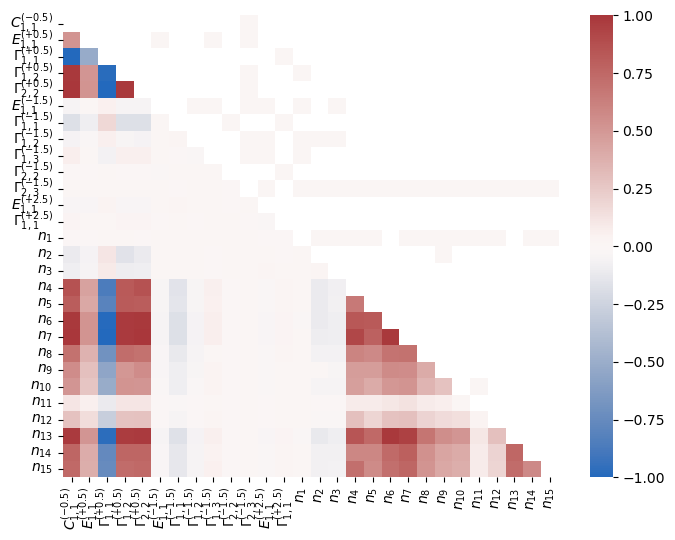

In [10]:
if( cov is not None ):

    # Calculate the correlation matrix
    corr = corr_from_cov(cov)
    mask = np.triu( corr )

    # Plot the correlation heatmap
    plt.figure(figsize=(8, 6))
    colormap = sns.color_palette("vlag", as_cmap=True)
    sns.heatmap( corr, vmin=-1, vmax=1, cmap=colormap, center=0, annot=False, fmt=".2f", mask=mask, xticklabels=azr.config.labels, yticklabels=azr.config.labels )

In [11]:
# All the data are in a single array, so we need to split them up
segments = azr.config.data.segments
lenghts = np.empty( shape=(len(segments)-1), dtype=int )
for idx, segment in enumerate(segments):
    if( idx == (len(segments) - 1) ): continue
    lenghts[idx] = len( segment.values )

x_split = np.split( x, np.cumsum(lenghts) )
y_split = np.split( y, np.cumsum(lenghts) )
dy_split = np.split( dy_bare, np.cumsum(lenghts) )

In [12]:
# Number of samples
nsamples = 1000

# Sample the covariance matrix
samples = np.random.multivariate_normal( m.values, cov, nsamples )

# Calculate the S-factor for each sample
bucket = {}
for i in tqdm( range( nsamples ) ):
    output = np.vstack(azr.predict(samples[i], dress_up=False))
    output = np.split( output, np.cumsum(lenghts) )
    for idx in range( len( output ) ):
        if( idx not in bucket ): bucket[idx] = []
        else: bucket[idx].append( output[idx] )

/var/folders/13/_3g2lmwx6xl3zshjv1d7yz4c0000gn/T/ipykernel_76851/3837538052.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal( m.values, cov, nsamples )
100%|██████████| 1000/1000 [03:09<00:00,  5.27it/s]


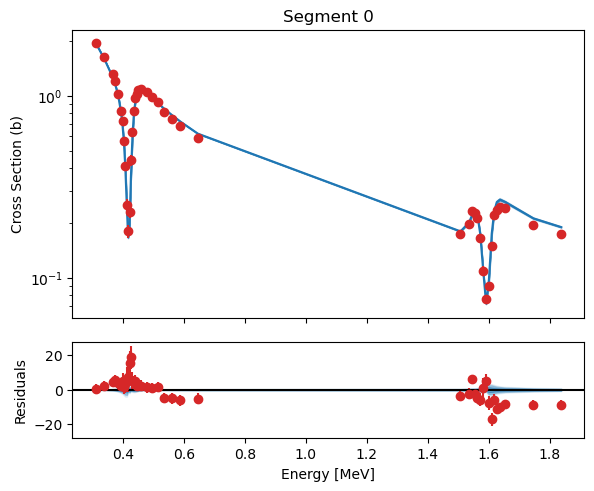

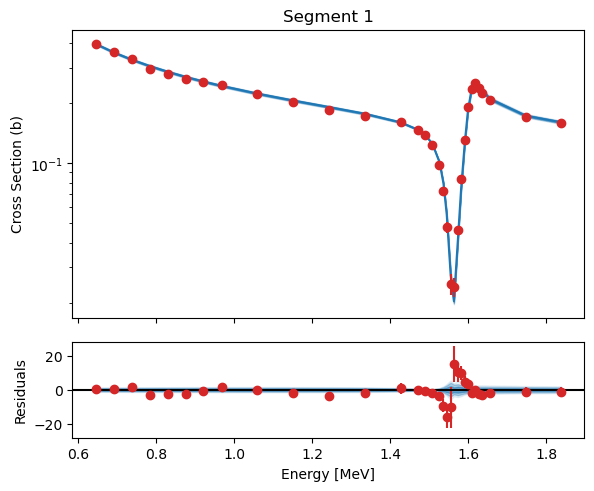

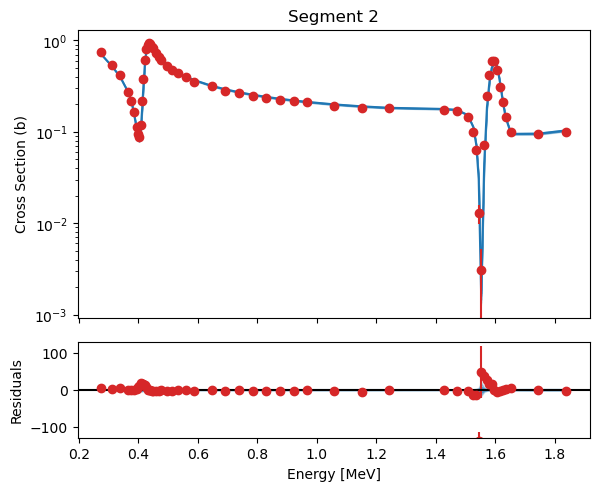

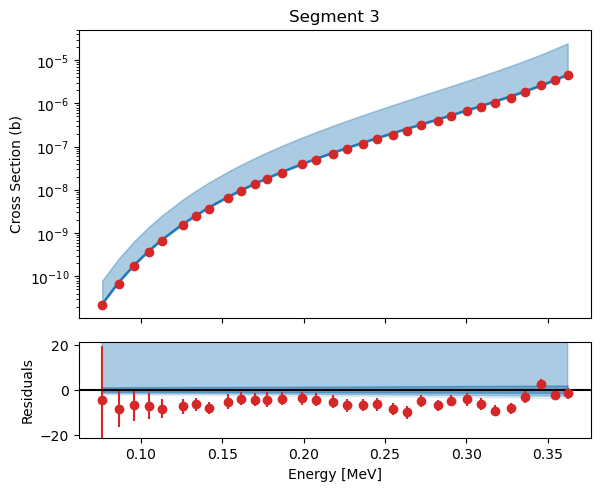

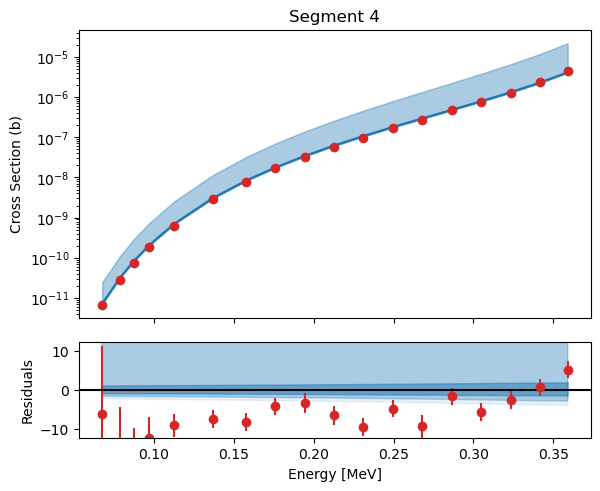

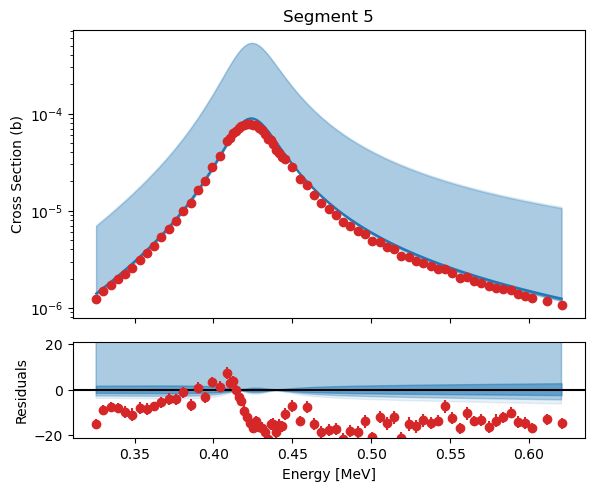

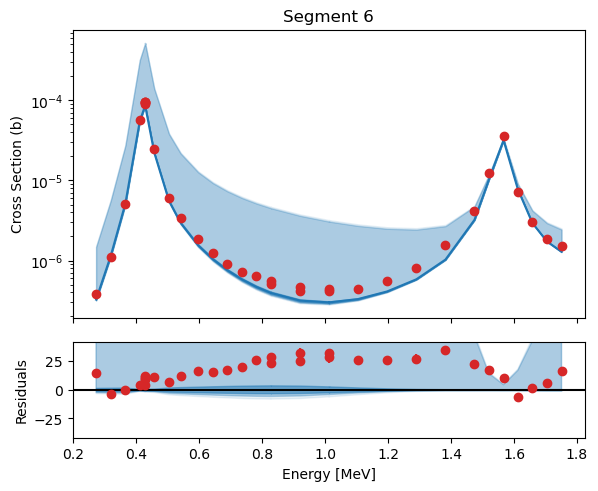

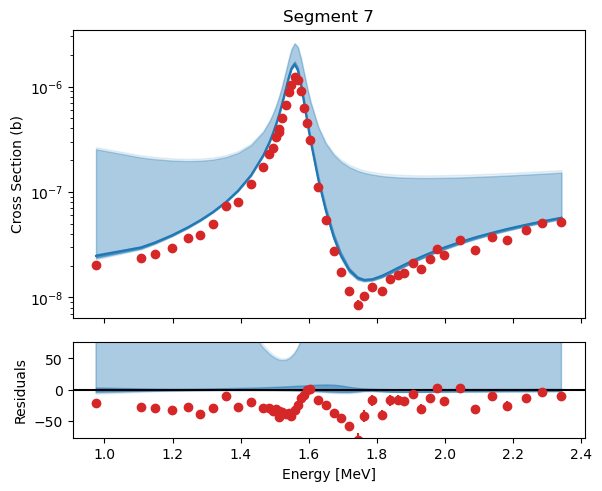

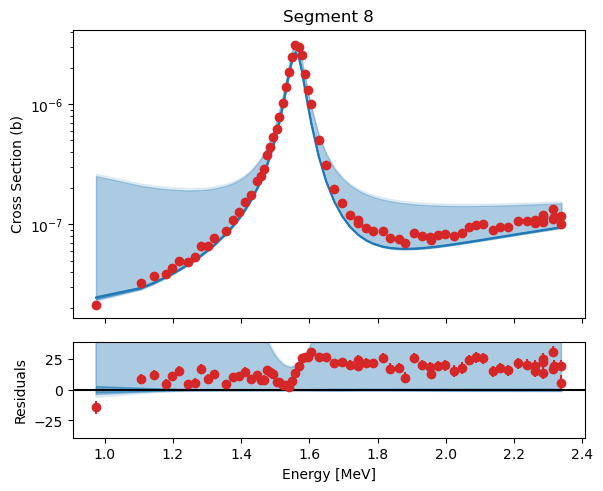

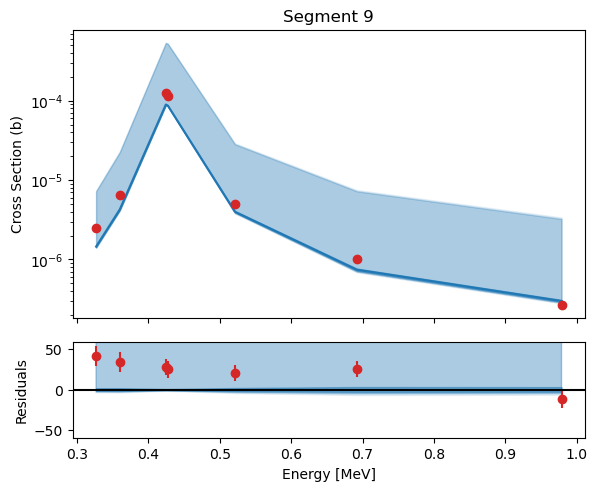

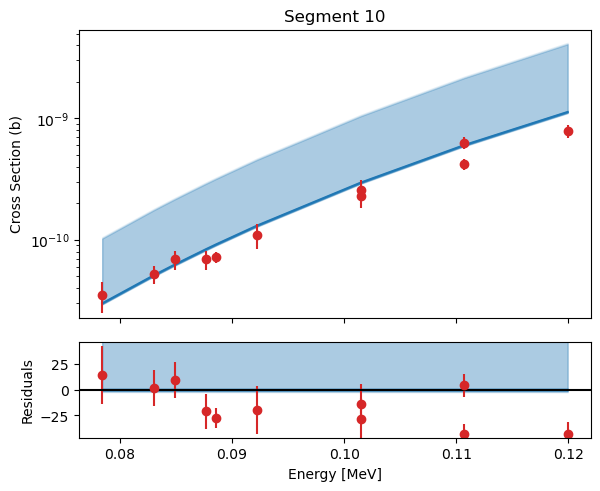

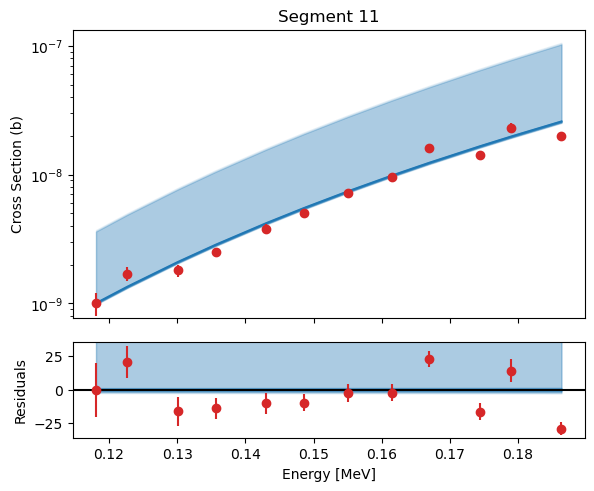

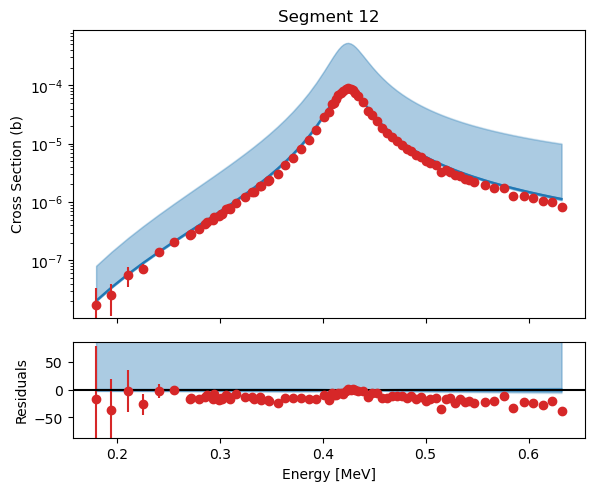

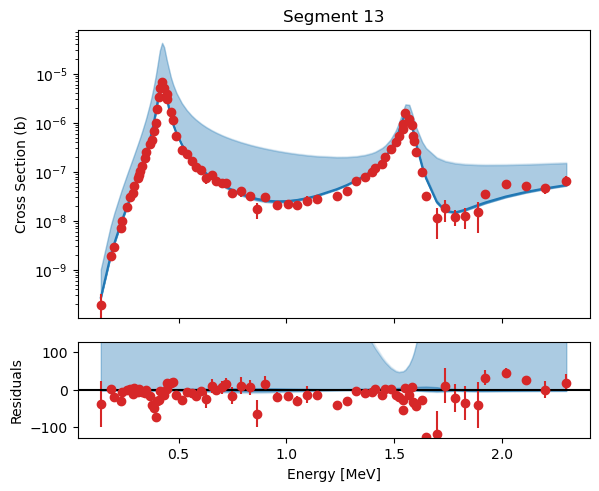

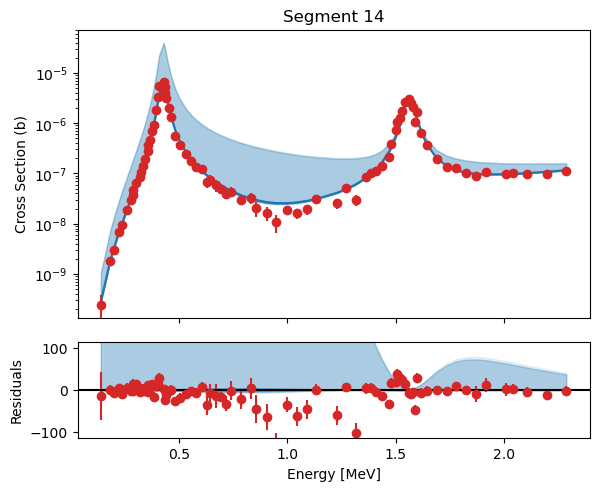

In [13]:
for i in range( len( segments ) ):

    # Now we plot the 1, 2 and 3 sigmas confidence intervals
    fig1 = plt.figure( )
    ax1 = fig1.add_axes((.1,.35,.8,.6))
    ax1.set_ylabel( "Cross Section (b)" )
    ax1.set_yscale( 'log' )
    ax1.set_xticklabels([])
    ax1.set_title( "Segment {}".format( i ) )

    bucket[i] = np.asarray( bucket[i] )

    quant_sigma1_low = np.zeros( len( x_split[i] ) )
    quant_sigma1_up  = np.zeros( len( x_split[i] ) )
    quant_sigma2_low = np.zeros( len( x_split[i] ) )
    quant_sigma2_up  = np.zeros( len( x_split[i] ) )
    quant_sigma3_low = np.zeros( len( x_split[i] ) )
    quant_sigma3_up  = np.zeros( len( x_split[i] ) )
    quant_mean       = np.zeros( len( x_split[i] ) )

    for j in range( len( x_split[i] ) ):
        quant_sigma1_low[j] = np.quantile( bucket[i][:,j,3], 0.158 )
        quant_sigma1_up[j]  = np.quantile( bucket[i][:,j,3], 0.841 )
        quant_sigma2_low[j] = np.quantile( bucket[i][:,j,3], 0.023 )
        quant_sigma2_up[j]  = np.quantile( bucket[i][:,j,3], 0.977 )
        quant_sigma3_low[j] = np.quantile( bucket[i][:,j,3], 0.002 )
        quant_sigma3_up[j]  = np.quantile( bucket[i][:,j,3], 0.998 )
        quant_mean[j]       = np.quantile( bucket[i][:,j,3], 0.5   )

    ax1.plot( x_split[i], quant_mean, color="tab:blue", label='Mean' )
    ax1.errorbar( x_split[i], y_split[i], yerr=dy_split[i], color="tab:red", fmt="o", label='{}'.format( labels[i] ) )
    ax1.fill_between( x_split[i], quant_sigma1_low, quant_sigma1_up, color="tab:blue", alpha=0.5, label='1 sigma' )
    ax1.fill_between( x_split[i], quant_sigma2_low, quant_sigma2_up, color="tab:blue", alpha=0.3, label='2 sigma' )
    ax1.fill_between( x_split[i], quant_sigma3_low, quant_sigma3_up, color="tab:blue", alpha=0.1, label='3 sigma' )

    percent = 100 * ( y_split[i] - quant_mean ) / y_split[i]
    percent_err = 100 * ( dy_split[i] / y_split[i] )
    max_percent = max( abs( percent + percent_err ) )

    ax2 = fig1.add_axes((.1,.1,.8,.2))
    ax2.errorbar( x_split[i], percent, yerr=percent_err, fmt="o", color="tab:red" )
    ax2.fill_between( x_split[i], 100 * ( quant_sigma1_low - quant_mean ) / quant_mean, 100 * ( quant_sigma1_up - quant_mean ) / quant_mean, color="tab:blue", alpha=0.5, label='1 sigma' )
    ax2.fill_between( x_split[i], 100 * ( quant_sigma2_low - quant_mean )/ quant_mean, 100 * ( quant_sigma2_up - quant_mean ) / quant_mean, color="tab:blue", alpha=0.3, label='2 sigma' )
    ax2.fill_between( x_split[i], 100 * ( quant_sigma3_low - quant_mean ) / quant_mean, 100 * ( quant_sigma3_up - quant_mean ) / quant_mean, color="tab:blue", alpha=0.1, label='3 sigma' )
    ax2.axhline( 0, color="black" )
    ax2.set_xlabel( "Energy [MeV]" )
    ax2.set_ylabel( "Residuals" )
    ax2.set_ylim( -max_percent * 1.1, max_percent * 1.1 )

plt.show( )